# Part 1, Model 1B: Basic Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus, the optic cup, and the optic disk images of the eye. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-25 13:22:51.044853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 13:22:51.044954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 13:22:51.133269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 13:22:51.292313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 13:22:54.213975: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data[data['fundus_oc_seg'].notnull() & data['fundus_od_seg'].notnull()].info()

print(data['fundus_oc_seg'].notnull().value_counts())

data[data['fundus_oc_seg'].notnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 4546 to 12048
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     3102 non-null   object 
 1   types                     3102 non-null   int64  
 2   type_expanded             1848 non-null   object 
 3   isColor                   3102 non-null   int64  
 4   original_name             3102 non-null   object 
 5   patient_id                488 non-null    object 
 6   fundus                    3102 non-null   object 
 7   fundus_od_seg             3102 non-null   object 
 8   fundus_oc_seg             3102 non-null   object 
 9   bv_seg                    0 non-null      object 
 10  artery_seg                0 non-null      object 
 11  vein_seg                  0 non-null      object 
 12  oct                       44 non-null     object 
 13  oct_oc_seg                44 non-null     object 
 14  oct_od_se

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
4546,ORIGA-1,0,NaN,1,001.jpg,NaN,/full-fundus/ORIGA-1.png,/optic-disc/ORIGA-1.png,/optic-cup/ORIGA-1.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,ORIGA-2,0,NaN,1,002.jpg,NaN,/full-fundus/ORIGA-2.png,/optic-disc/ORIGA-2.png,/optic-cup/ORIGA-2.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,ORIGA-3,0,NaN,1,003.jpg,NaN,/full-fundus/ORIGA-3.png,/optic-disc/ORIGA-3.png,/optic-cup/ORIGA-3.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,ORIGA-4,0,NaN,1,004.jpg,NaN,/full-fundus/ORIGA-4.png,/optic-disc/ORIGA-4.png,/optic-cup/ORIGA-4.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,ORIGA-5,0,NaN,1,005.jpg,NaN,/full-fundus/ORIGA-5.png,/optic-disc/ORIGA-5.png,/optic-cup/ORIGA-5.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,PAPILA-484,0,Healthy,1,289,PAPILA-289,/full-fundus/PAPILA-484.png,/optic-disc/PAPILA-484.png,/optic-cup/PAPILA-484.png,NaN,...,NaN,0.75,-1.5,93,1,10,,531,22.31,
12045,PAPILA-485,0,Healthy,1,290,PAPILA-290,/full-fundus/PAPILA-485.png,/optic-disc/PAPILA-485.png,/optic-cup/PAPILA-485.png,NaN,...,NaN,0.25,-0.25,160,1,19,,573,22.01,
12046,PAPILA-486,0,Healthy,1,291,PAPILA-291,/full-fundus/PAPILA-486.png,/optic-disc/PAPILA-486.png,/optic-cup/PAPILA-486.png,NaN,...,NaN,1.5,-1.25,76,0,14,,443,23.51,
12047,PAPILA-487,0,Healthy,1,292,PAPILA-292,/full-fundus/PAPILA-487.png,/optic-disc/PAPILA-487.png,/optic-cup/PAPILA-487.png,NaN,...,NaN,1.25,-0.75,79,0,9,,479,23.84,


In [8]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [10]:
data['fundus_oc_seg'][12044]

'/optic-cup/PAPILA-484.png'

In [11]:
data['fundus_od_seg'][12044]

'/optic-disc/PAPILA-484.png'

In [12]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


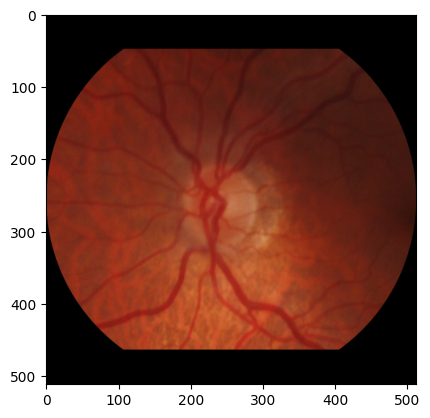

optic-cup/optic-cup/PAPILA-484.png


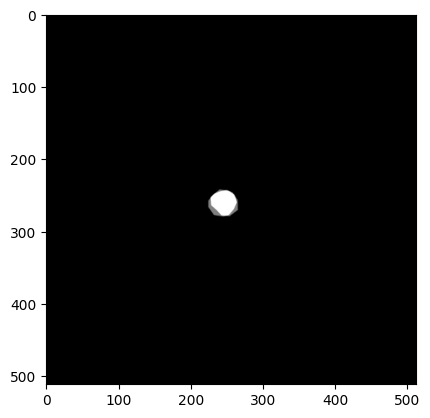

optic-disc/optic-disc/PAPILA-484.png


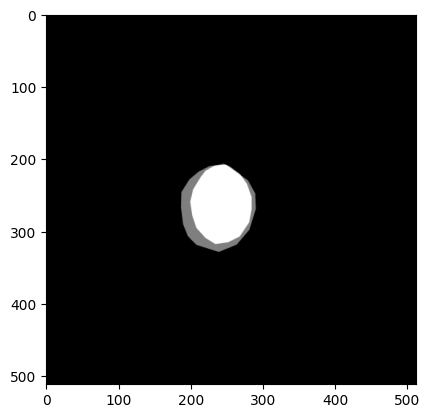

In [13]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [14]:
data["types"].value_counts()

types
 0    7549
 1    4767
-1     133
Name: count, dtype: int64

In [15]:
data["types"].value_counts().sum()

12449

In [16]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
data = data [

    (data['fundus'].notnull()) &
    (data['fundus_oc_seg'].notnull()) & 
    (data['fundus_od_seg'].notnull()) & (data['types'] != -1)
]

fundus_subset = data[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 4546 to 12048
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   types          3034 non-null   object
 1   fundus         3034 non-null   object
 2   fundus_oc_seg  3034 non-null   object
 3   fundus_od_seg  3034 non-null   object
 4   names          3034 non-null   object
 5   combined       3034 non-null   object
dtypes: object(6)
memory usage: 165.9+ KB


/tmp/ipykernel_7294/1673553536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_7294/1673553536.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_7294/1673553536.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [17]:
fundus_subset['types'].value_counts()

types
0    2310
1     724
Name: count, dtype: int64

In [18]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,ORIGA-2.png
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,ORIGA-3.png
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,ORIGA-4.png
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,ORIGA-5.png
...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,PAPILA-484.png
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,PAPILA-485.png
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,PAPILA-486.png
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,PAPILA-487.png


In [19]:
fundus_subset[fundus_subset['combined'] == 'G1020-107.png']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
7378,1,/full-fundus/G1020-107.png,Not Visible,/optic-disc/G1020-107.png,G1020-107,G1020-107.png


In [20]:
#show me the instances in fundus column that say Not Visible

fundus_subset[fundus_subset['fundus'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined


In [21]:
#show me the instances in fundus_oc_seg column that say Not Visible

fundus_subset[fundus_subset['fundus_oc_seg'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
7276,0,/full-fundus/G1020-5.png,Not Visible,/optic-disc/G1020-5.png,G1020-5,G1020-5.png
7278,0,/full-fundus/G1020-7.png,Not Visible,/optic-disc/G1020-7.png,G1020-7,G1020-7.png
7279,0,/full-fundus/G1020-8.png,Not Visible,/optic-disc/G1020-8.png,G1020-8,G1020-8.png
7284,1,/full-fundus/G1020-13.png,Not Visible,/optic-disc/G1020-13.png,G1020-13,G1020-13.png
7285,1,/full-fundus/G1020-14.png,Not Visible,/optic-disc/G1020-14.png,G1020-14,G1020-14.png
...,...,...,...,...,...,...
8256,1,/full-fundus/G1020-985.png,Not Visible,/optic-disc/G1020-985.png,G1020-985,G1020-985.png
8261,0,/full-fundus/G1020-990.png,Not Visible,/optic-disc/G1020-990.png,G1020-990,G1020-990.png
8275,1,/full-fundus/G1020-1004.png,Not Visible,/optic-disc/G1020-1004.png,G1020-1004,G1020-1004.png
8281,0,/full-fundus/G1020-1010.png,Not Visible,/optic-disc/G1020-1010.png,G1020-1010,G1020-1010.png


In [22]:
#show me the instances in fundus_od_seg column that say Not Visible

fundus_subset[fundus_subset['fundus_od_seg'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined


In [23]:
# remove instances that say Not Visible in fundus column
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

In [24]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,ORIGA-2.png
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,ORIGA-3.png
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,ORIGA-4.png
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,ORIGA-5.png
...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,PAPILA-484.png
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,PAPILA-485.png
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,PAPILA-486.png
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,PAPILA-487.png


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming fundus_subset is your DataFrame and 'types' is the column with labels
# Also assuming you have 'fundus_subset_random' DataFrame created earlier

testSize = 500
valSize = 500

# Calculate the number of samples for each class
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

print('Total fundus images to  be used: ', glaucomaCount + healthyCount)

# Set the random seed for reproducibility
random_state = 1

# Create StratifiedShuffleSplit instance for test set
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Create StratifiedShuffleSplit instance for validation set
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set, train_set['types']):
    train = train_set.iloc[train_index]
    val = train_set.iloc[val_index]

# Now train_set_final, val_set, and test_set contain the stratified splits

# Print the counts for each set
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# You can access the features and labels as needed:
train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140
Total fundus images to  be used:  2805

Train set size: 1805
Validation set size: 500
Test set size: 500


In [26]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  1805
Test Size:  500


In [27]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-25 13:22:59.554859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 13:22:59.826227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 13:22:59.826871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


# Set target size and batch size for data generator
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-02-25 13:22:59.857175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 13:22:59.857876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 13:22:59.858378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 13:23:00.346399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 13:23:00.347017: I external/local_xla/xla/stream_executor

Found 1805 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [29]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 1805 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 1805 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [31]:
from keras.applications import MobileNetV3Small
from keras import Sequential

input_shape = (target, target, 3)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

def extract_features(generator, sample_count):
    
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [32]:
import numpy as np

with tf.device('/GPU:0'):

    train_features1, train_labels1 = extract_features(trainGen1, trainGen1.samples)
    val_features1, val_labels1 = extract_features(valGen1, valGen1.samples)
    test_features1, test_labels1 = extract_features(testGen1, testGen1.samples)

2024-02-25 13:23:23.166813: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-25 13:23:23.661714: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


2024-02-25 13:23:24.426719: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 35ms/step


In [33]:
import numpy as np

with tf.device('/GPU:0'):

    train_features2, train_labels2 = extract_features(trainGen2, trainGen2.samples)
    val_features2, val_labels2 = extract_features(valGen2, valGen2.samples)
    test_features2, test_labels2 = extract_features(testGen2, testGen2.samples)

1/1 [==============================] - 0s 45ms/step


In [34]:
import numpy as np

with tf.device('/GPU:0'):

    train_features3, train_labels3 = extract_features(trainGen3, trainGen3.samples)
    val_features3, val_labels3 = extract_features(valGen3, valGen3.samples)
    test_features3, test_labels3 = extract_features(testGen3, testGen3.samples)

1/1 [==============================] - 0s 65ms/step


In [35]:
# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

with tf.device('/GPU:0'):

    # Set class mode to 'sparse' for visualization data generators
    classes = 'sparse'

    # Create data generators for healthy and glaucoma subsets for visualization
    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = healthy_subsetDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2140 validated image filenames belonging to 1 classes.
Found 665 validated image filenames belonging to 1 classes.


In [36]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

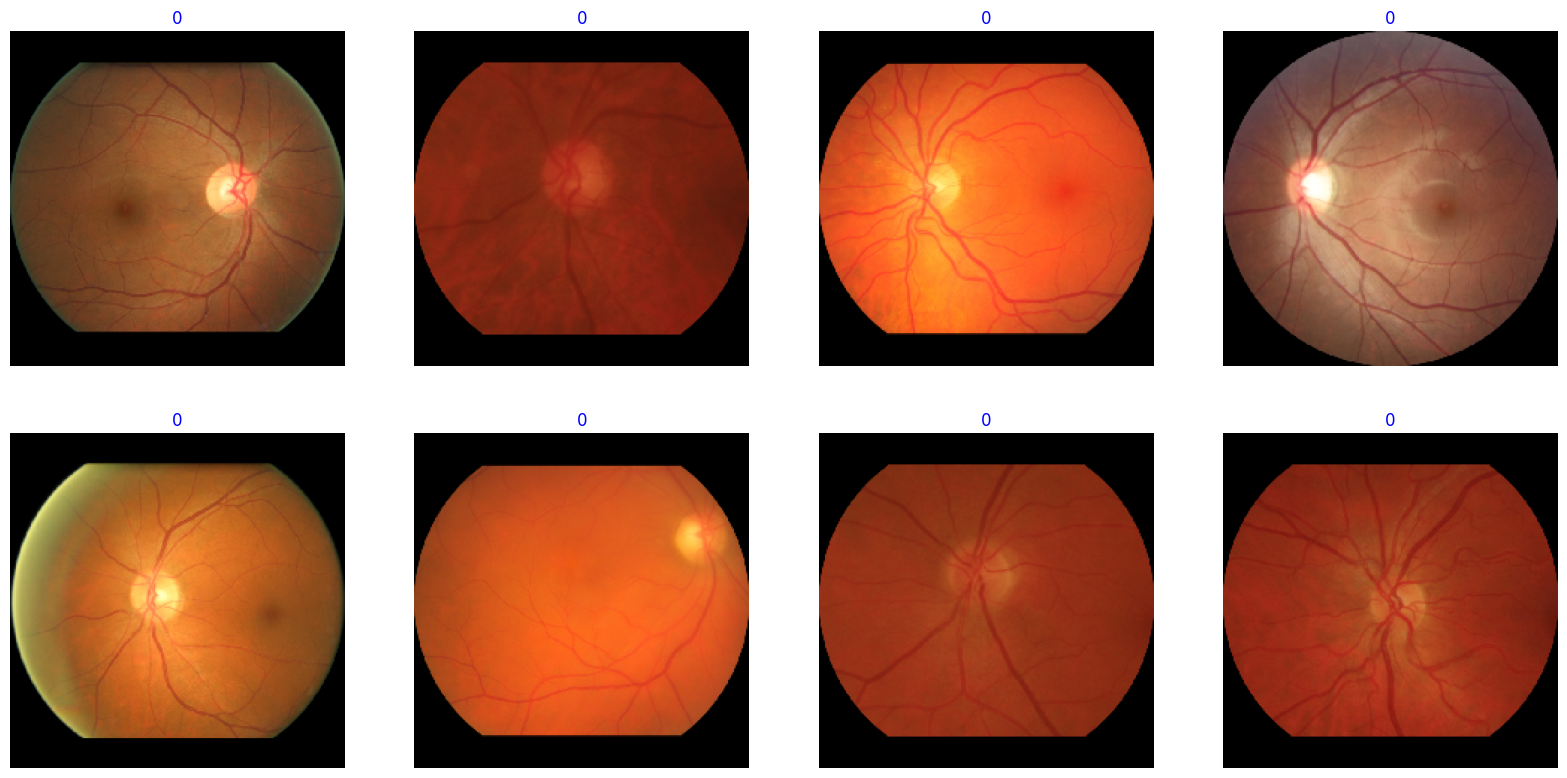

In [37]:
show_images(healthy_subset_Gen)

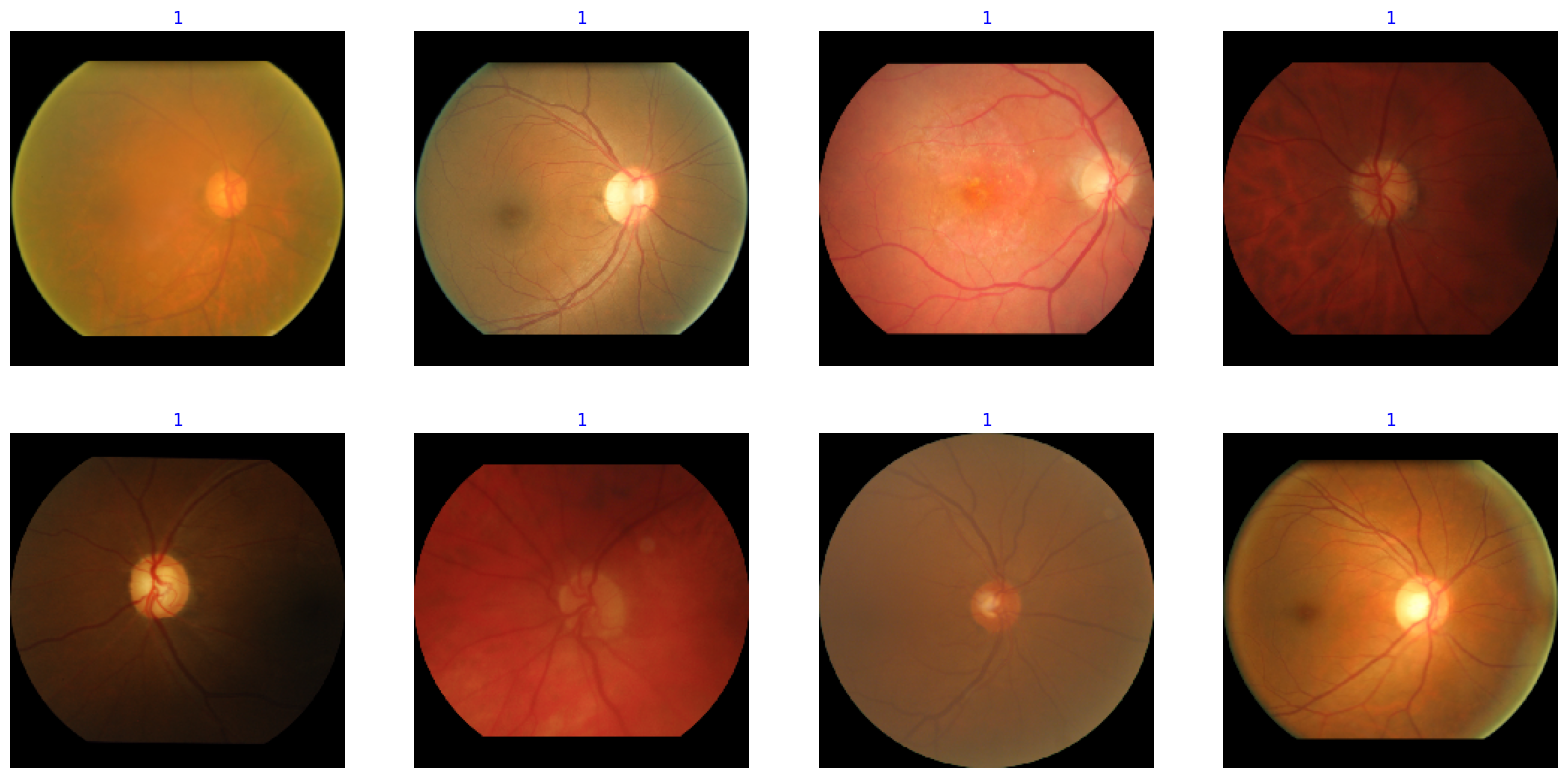

In [38]:
show_images(glaucoma_subset_Gen)

In [39]:
import numpy as np

# Combine train features and labels
train_features_combined = np.concatenate((train_features1, train_features2, train_features3), axis=0)
train_labels_combined = np.concatenate((train_labels1, train_labels2, train_labels3), axis=0)

# Combine validation features and labels
val_features_combined = np.concatenate((val_features1, val_features2, val_features3), axis=0)
val_labels_combined = np.concatenate((val_labels1, val_labels2, val_labels3), axis=0)

# Combine test features and labels
test_features_combined = np.concatenate((test_features1, test_features2, test_features3), axis=0)
test_labels_combined = np.concatenate((test_labels1, test_labels2, test_labels3), axis=0)

In [40]:
#print the shape of the combined features and labels

print("Train Features Shape: ", train_features_combined.shape)
print("Train Labels Shape: ", train_labels_combined.shape)

print("Validation Features Shape: ", val_features_combined.shape)
print("Validation Labels Shape: ", val_labels_combined.shape)

print("Test Features Shape: ", test_features_combined.shape)
print("Test Labels Shape: ", test_labels_combined.shape)

Train Features Shape:  (5415, 576)
Train Labels Shape:  (5415,)
Validation Features Shape:  (1500, 576)
Validation Labels Shape:  (1500,)
Test Features Shape:  (1500, 576)
Test Labels Shape:  (1500,)


In [41]:
from sklearn.svm import SVC

# Create and train the SVM with the combined features and labels
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_combined, train_labels_combined)

SVC(kernel='linear', probability=True)

In [42]:
# Validate the SVM with the combined validation set
val_accuracy_combined = svm_model.score(val_features_combined, val_labels_combined)
print('Combined Validation accuracy:', val_accuracy_combined)

# Test the SVM with the combined test set
test_accuracy_combined = svm_model.score(test_features_combined, test_labels_combined)
print('Combined Test accuracy:', test_accuracy_combined)

Combined Validation accuracy: 0.7606666666666667
Combined Test accuracy: 0.766


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions with the combined test set
test_predictions_combined = svm_model.predict(test_features_combined)

# Calculate the confusion matrix and classification report using the combined test labels and predictions
conf_matrix_combined = confusion_matrix(test_labels_combined, test_predictions_combined)
class_report_combined = classification_report(test_labels_combined, test_predictions_combined)

# Print the confusion matrix
print("Combined Confusion Matrix:")
print(conf_matrix_combined)

# Print the classification report
print("\nCombined Classification Report:")
print(class_report_combined)

Combined Confusion Matrix:
[[1097   46]
 [ 305   52]]

Combined Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86      1143
         1.0       0.53      0.15      0.23       357

    accuracy                           0.77      1500
   macro avg       0.66      0.55      0.55      1500
weighted avg       0.72      0.77      0.71      1500



In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the KNN model with the combined features and labels
knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)
knn_model.fit(train_features_combined, train_labels_combined)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [45]:
# Validate the KNN with the combined validation set
val_accuracy_combined = knn_model.score(val_features_combined, val_labels_combined)
print('Combined Validation accuracy:', val_accuracy_combined)

# Test the KNN with the combined test set
test_accuracy_combined = knn_model.score(test_features_combined, test_labels_combined)
print('Combined Test accuracy:', test_accuracy_combined)

Combined Validation accuracy: 0.748
Combined Test accuracy: 0.752


In [46]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions with the combined test set
test_predictions_combined = knn_model.predict(test_features_combined)

# Calculate the confusion matrix and classification report using the combined test labels and predictions
conf_matrix_combined = confusion_matrix(test_labels_combined, test_predictions_combined)
class_report_combined = classification_report(test_labels_combined, test_predictions_combined)

# Print the combined confusion matrix
print("Combined Confusion Matrix:")
print(conf_matrix_combined)

# Print the combined classification report
print("\nCombined Classification Report:")
print(class_report_combined)

Combined Confusion Matrix:
[[1051   92]
 [ 280   77]]

Combined Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      1143
         1.0       0.46      0.22      0.29       357

    accuracy                           0.75      1500
   macro avg       0.62      0.57      0.57      1500
weighted avg       0.71      0.75      0.72      1500



In [47]:
import xgboost as xgb

# Create and train the XGBoost model with the combined training set
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_features_combined, train_labels_combined)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [48]:
# Validate the XGBoost model with the combined validation set
val_accuracy_combined = xgb_model.score(val_features_combined, val_labels_combined)
print('Combined Validation accuracy:', val_accuracy_combined)

# Test the XGBoost model with the combined test set
test_accuracy_combined = xgb_model.score(test_features_combined, test_labels_combined)
print('Combined Test accuracy:', test_accuracy_combined)

Combined Validation accuracy: 0.76
Combined Test accuracy: 0.7553333333333333


In [49]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions with the combined test set
test_predictions_combined = xgb_model.predict(test_features_combined)

# Calculate the confusion matrix and classification report using the combined test labels and predictions
conf_matrix_combined = confusion_matrix(test_labels_combined, test_predictions_combined)
class_report_combined = classification_report(test_labels_combined, test_predictions_combined, digits=4)

# Print the combined confusion matrix
print("Combined Confusion Matrix:")
print(conf_matrix_combined)

# Print the combined classification report
print("\nCombined Classification Report:")
print(class_report_combined)

Combined Confusion Matrix:
[[1049   94]
 [ 273   84]]

Combined Classification Report:
              precision    recall  f1-score   support

         0.0     0.7935    0.9178    0.8511      1143
         1.0     0.4719    0.2353    0.3140       357

    accuracy                         0.7553      1500
   macro avg     0.6327    0.5765    0.5826      1500
weighted avg     0.7170    0.7553    0.7233      1500



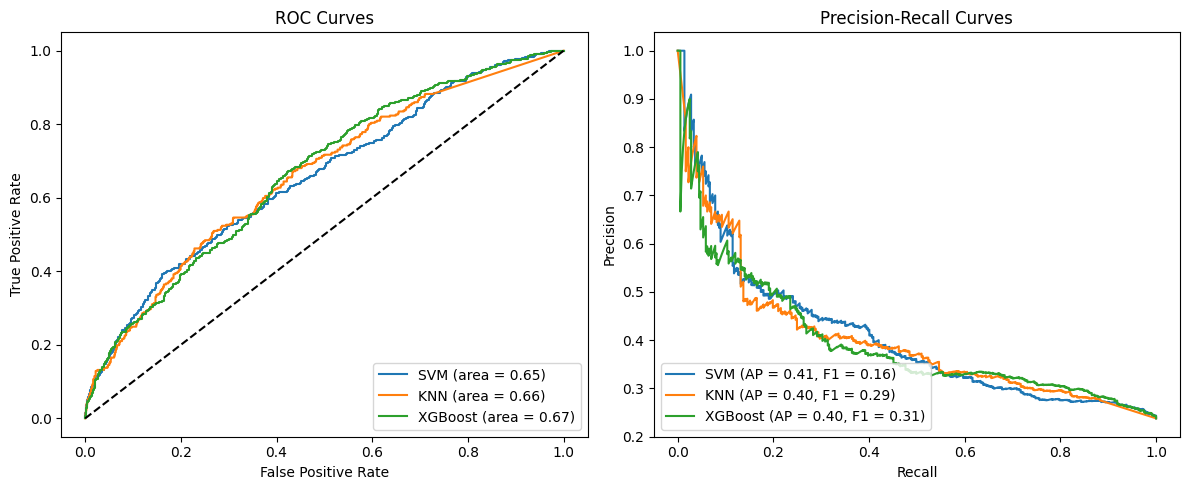

In [50]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Use the combined test labels for the true labels
true_labels = test_labels_combined

# Generate the predicted probabilities using the combined test features
svm_probs = svm_model.predict_proba(test_features_combined)[:, 1]
knn_probs = knn_model.predict_proba(test_features_combined)[:, 1]
xgb_probs = xgb_model.predict_proba(test_features_combined)[:, 1]

# Calculate ROC curve and ROC area for each model
fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate Precision-Recall curve and F1 score for each model
precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, (svm_probs > 0.5).astype(int))

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, (knn_probs > 0.5).astype(int))

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, (xgb_probs > 0.5).astype(int))

# Plot all ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot all Precision-Recall curves
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()
